**Jupyter notebook avaialble @ [https://github.com/dhiraa/tf-guru/blob/master/dataset/2017-11-11-TFRecord.ipynb](https://github.com/dhiraa/tf-guru/blob/master/dataset/2017-11-11-TFRecord.ipynb)**

In [1]:
import tensorflow as tf
import numpy as np
import tempfile

# Sequence

### Preprocessing Data: [Use tf.SequenceExample](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/example/example.proto)

```
Data ---> Preprocessing ---> TFRecords ---> Input Graph ---> Model
```

RNNs are used for sequential data that has inputs and/or outputs at multiple time steps. Tensorflow comes with a protocol buffer definition to deal with such data: `tf.SequenceExample`.


You can load data directly from your Python/Numpy arrays, but it’s probably in your best interest to use tf.SequenceExample instead. This data structure consists of a “context” for non-sequential features and “feature_lists” for sequential features. It’s somewhat verbose (it blew up my latest dataset by 10x), but it comes with a few benefits that are worth it:

- **Easy distributed training.** Split up data into multiple TFRecord files, each containing many SequenceExamples, and use Tensorflow’s built-in support for distributed training.
- **Reusability.** Other people can re-use your model by bringing their own data into tf.SequenceExample format. No model code changes required.
- **Use of Tensorflow data loading pipelines functions like tf.parse_single_sequence_example.** Libraries like tf.learn also come with convenience function that expect you to feed data in protocol buffer format.
- **Separation of data preprocessing and model code.** Using tf.SequenceExample forces you to separate your data preprocessing and Tensorflow model code. This is good practice, as your model shouldn’t make any assumptions about the input data it gets.


In practice, you write a little script that converts your data into tf.SequenceExample format and then writes one or more TFRecord files. These TFRecord files are parsed by Tensorflow to become the input to your model:

- Convert your data into tf.SequenceExample format
- Write one or more TFRecord files with the serialized data
- Use tf.TFRecordReader to read examples from the file
- Parse each example using tf.parse_single_sequence_example (Not in the official docs yet)

In [2]:

sequences = [[1, 2, 3], [4, 5, 1], [1, 2]]
label_sequences = [[0, 1, 0], [1, 0, 0], [1, 1]]

def make_example(sequence, labels):
    # The object we return
    example_sequence = tf.train.SequenceExample()
    # A non-sequential feature of our example
    sequence_length = len(sequence)
    example_sequence.context.feature["length"].int64_list.value.append(sequence_length)
    # Feature lists for the two sequential features of our example
    fl_tokens = example_sequence.feature_lists.feature_list["tokens"]
    fl_labels = example_sequence.feature_lists.feature_list["labels"]
    for token, label in zip(sequence, labels):
        fl_tokens.feature.add().int64_list.value.append(token)
        fl_labels.feature.add().int64_list.value.append(label)
    return example_sequence



In [3]:
# A single serialized example
# (You can read this from a file using TFRecordReader)
example_sequence = make_example([1, 2, 3], [0, 1, 0]).SerializeToString()

# Define how to parse the example
context_features = {
    "length": tf.FixedLenFeature([], dtype=tf.int64)
}
sequence_features = {
    "tokens": tf.FixedLenSequenceFeature([], dtype=tf.int64), #tf.VarLenFeature(tf.int64),
    "labels": tf.FixedLenSequenceFeature([], dtype=tf.int64)
}


In [4]:
# Parse the example (returns a dictionary of tensors)
context_parsed, sequence_parsed = tf.parse_single_sequence_example(
    serialized=example_sequence,
    context_features=context_features,
    sequence_features=sequence_features
)

In [5]:
with tf.Session() as sess:
    print(sess.run(context_parsed))
    print(sess.run(sequence_parsed))

{'length': 3}
{'labels': array([0, 1, 0]), 'tokens': array([1, 2, 3])}


### Write all examples into a TFRecords file

In [6]:
def save_into_tfrecord(sequences, label_sequences):
    with open("/tmp/dummy.tfrecord", "wb") as fp:
        
        writer = tf.python_io.TFRecordWriter(fp.name)
        #get each sequence along with its labels and write it to a file as Sequence Example.
        for sequence, label_sequence in zip(sequences, label_sequences):
            example_sequence = make_example(sequence, label_sequence)
            writer.write(example_sequence.SerializeToString())
        writer.close()
        print("Wrote to {}".format(fp.name))
        return fp.name

In [7]:
filename = save_into_tfrecord(sequences, label_sequences)
filename

Wrote to /tmp/dummy.tfrecord


'/tmp/dummy.tfrecord'

In [8]:
def read_and_decode_single_example(filename):

    filename_queue = tf.train.string_input_producer([filename],
                                                num_epochs=None)

    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)

    # Define how to parse the example
    context_features = {
        "length": tf.FixedLenFeature([], dtype=tf.int64)
    }
    sequence_features = {
        "tokens": tf.FixedLenSequenceFeature([], dtype=tf.int64), #tf.VarLenFeature(tf.int64),
        "labels": tf.FixedLenSequenceFeature([], dtype=tf.int64)
    }


    return serialized_example, context_features, sequence_features

example_sequence,context_features,sequence_features = read_and_decode_single_example(filename)

example_sequence,context_features,sequence_features

(<tf.Tensor 'ReaderReadV2:1' shape=() dtype=string>,
 {'length': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)},
 {'labels': FixedLenSequenceFeature(shape=[], dtype=tf.int64, allow_missing=False, default_value=None),
  'tokens': FixedLenSequenceFeature(shape=[], dtype=tf.int64, allow_missing=False, default_value=None)})

In [9]:
# Parse the example (returns a dictionary of tensors)
context_parsed, sequence_parsed = tf.parse_single_sequence_example(
    serialized=example_sequence,
    context_features=context_features,
    sequence_features=sequence_features
)

In [10]:
with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    print(sess.run(context_parsed))
    print(sess.run(sequence_parsed))

{'length': 3}
{'labels': array([1, 0, 0]), 'tokens': array([4, 5, 1])}
INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: input_producer/input_producer_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](input_producer, input_producer/RandomShuffle)]]


# Images

In [11]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [12]:
IMAGE_PATH = '../data/'

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def get_image_binary(filename):
    """ You can read in the image using tensorflow too, but it's a drag
        since you have to create graphs. It's much easier using Pillow and NumPy
    """
    image = Image.open(filename)
    image = np.asarray(image, np.uint8)
    shape = np.array(image.shape, np.int32)
    return shape.tobytes(), image.tobytes() # convert image to raw data bytes in the array.

def write_to_tfrecord(label, shape, binary_image, tfrecord_file):
    """ This example is to write a sample to TFRecord file. If you want to write
    more samples, just use a loop.
    """
    writer = tf.python_io.TFRecordWriter(tfrecord_file)
    # write label, shape, and image content to the TFRecord file
    example = tf.train.Example(features=tf.train.Features(feature={
                'label': _int64_feature(label),
                'shape': _bytes_feature(shape),
                'image': _bytes_feature(binary_image)
                }))
    writer.write(example.SerializeToString())
    writer.close()

def write_tfrecord(label, image_file, tfrecord_file):
    shape, binary_image = get_image_binary(image_file)
    write_to_tfrecord(label, shape, binary_image, tfrecord_file)

def read_from_tfrecord(filenames):
    tfrecord_file_queue = tf.train.string_input_producer(filenames, name='queue')
    reader = tf.TFRecordReader()
    _, tfrecord_serialized = reader.read(tfrecord_file_queue)

    # label and image are stored as bytes but could be stored as 
    # int64 or float64 values in a serialized tf.Example protobuf.
    tfrecord_features = tf.parse_single_example(tfrecord_serialized,
                        features={
                            'label': tf.FixedLenFeature([], tf.int64),
                            'shape': tf.FixedLenFeature([], tf.string),
                            'image': tf.FixedLenFeature([], tf.string),
                        }, name='features')
    # image was saved as uint8, so we have to decode as uint8.
    image = tf.decode_raw(tfrecord_features['image'], tf.uint8)
    shape = tf.decode_raw(tfrecord_features['shape'], tf.int32)
    # the image tensor is flattened out, so we have to reconstruct the shape
    image = tf.reshape(image, shape)
    label = tfrecord_features['label']
    return label, shape, image

def read_tfrecord(tfrecord_file):
    label, shape, image = read_from_tfrecord([tfrecord_file])

    with tf.Session() as sess:
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        label, image, shape = sess.run([label, image, shape])
        coord.request_stop()
        coord.join(threads)
    print(label)
    print(shape)
    plt.imshow(image)
    plt.show() 

1
[960 720   3]


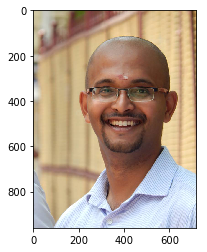

In [13]:
# assume the image has the label Chihuahua, which corresponds to class number 1
label = 1 
image_file = IMAGE_PATH + 'mageswaran.jpg'
tfrecord_file = IMAGE_PATH + 'friday.tfrecord'
write_tfrecord(label, image_file, tfrecord_file)
read_tfrecord(tfrecord_file)

![]({{"/tf-guru/assets/2017-11-11-TFRecord_files/2017-11-11-TFRecord_20_1.png" | relative_url }})

# Check this out for large image datasets
- https://github.com/kwotsin/create_tfrecords/tree/python-3.0
- https://kwotsin.github.io/tech/2017/01/29/tfrecords.html

In [14]:
# Convert this notebook for Docs
! jupyter nbconvert --to markdown --output-dir ../docs/_posts 2017-11-11-TFRecord.ipynb
! rm -rf ../docs/assets/2017-11-11-TFRecord_files
! mv ../docs/_posts/2017-11-11-TFRecord_files ../docs/assets/

[NbConvertApp] Converting notebook 2017-11-11-TFRecord.ipynb to markdown
[NbConvertApp] Support files will be in 2017-11-11-TFRecord_files/
[NbConvertApp] Making directory ../docs/_posts/2017-11-11-TFRecord_files
[NbConvertApp] Writing 10938 bytes to ../docs/_posts/2017-11-11-TFRecord.md
